In [16]:
# Загружаем библиотеки
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Задаем параметры для графика
sns.set(
    font_scale =1,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

# Проект 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

## Задание

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared. Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

Разобъем задания на разделы, чтобы удобнее было читать ревьюеру

### 1.1 Выгрузка и чтение данных

In [6]:
# Данные о времени регистрации
registration = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/6DgNIPoUfNCk9w', sep = ';')

# Данные о времени захода пользователей в приложение
auth = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/fjBXJbst_069pw', sep = ';')

In [4]:
registration.head(3)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [5]:
auth.head(3)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


In [7]:
# Объединение датафреймов в один по uid для дальнейшего решения кейса
df = registration.merge(auth, on=['uid'])
df = df.reindex(columns=['uid','reg_ts','auth_ts'])
df.head()

,uid,reg_ts,auth_ts
0,1,911382223,911382223
1,2,932683089,932683089
2,2,932683089,932921206
3,2,932683089,933393015
4,2,932683089,933875379


Изучим полученные данные, чтобы понять с чем имеем дело

In [7]:
# Посмотрим количество уникальных юзеров (заодно посмотрим на повторы)
len(df['uid'].unique())

1000000

In [8]:
# Дата/время первой записи во фрейме
datetime.utcfromtimestamp(df.reg_ts.min()).strftime('%Y-%m-%d')

'1998-11-18'

In [9]:
# Последняя дата/время фрейма
datetime.utcfromtimestamp(df.reg_ts.max()).strftime('%Y-%m-%d')

'2020-09-23'

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   uid      int64
 1   reg_ts   int64
 2   auth_ts  int64
dtypes: int64(3)
memory usage: 293.0 MB


In [16]:
df.shape

(9601013, 5)

In [8]:
# Чтобы в функции сразу отделить нужный кусок времени - предварительно преобразуем датафрейм
df['reg_ts'] = df['reg_ts'].apply(datetime.fromtimestamp)
df['auth_ts'] = df['auth_ts'].apply(datetime.fromtimestamp)
df_1 = df

In [9]:
df_1.head()

,uid,reg_ts,auth_ts
0,1,1998-11-18 12:43:43,1998-11-18 12:43:43
1,2,1999-07-23 02:38:09,1999-07-23 02:38:09
2,2,1999-07-23 02:38:09,1999-07-25 20:46:46
3,2,1999-07-23 02:38:09,1999-07-31 07:50:15
4,2,1999-07-23 02:38:09,1999-08-05 21:49:39


###  Промежуточные выводы после ознакомления с данными:
1. В итоговом датасете уникальных пользователей: 1000000. Остальные записи - повторная авторизация.
2. Временной промежуток, с которым работаем - с 1998-11-18 по 2020-09-23.

### 1.2 Функция для расчета Retention.

Нам необходимо по задания рассчитать Retention по дням от даты регистрации игрока.

In [27]:
def func_retention(data, start, finish):
    # start  - начало промежутка
    # finish - окончание промежутка

    # Сразу фильтр данных для нужного промежутка времени, чтобы функция работала быстрее
    df_selected = df_1.query("reg_ts > = @start and auth_ts <= @finish")
    df_selected['registration_date'] = pd.to_datetime(df_selected['reg_ts'].dt.date)
    df_selected['autorization_date'] = pd.to_datetime(df_selected['auth_ts'].dt.date)
    df_selected = df_selected.drop(['reg_ts', 'auth_ts'], axis=1)   
    #  вводим столбец где посчитаем сколько дней прошло с момента регистрации до конкретного захода
    df_selected['lifetime'] = df_selected['autorization_date'] - df_selected['registration_date']
           
    # Вычисление retention. Группируем по регистрации, заполняем пропуски, округляем.
    retention = df_selected.pivot_table(index='registration_date', columns='lifetime', values='uid', aggfunc = 'nunique')
    retention = retention.divide(retention.iloc[:,0],axis='index').iloc[:-1, 1:].fillna(0).round(3)

    # Визуализируем данные
    plt.figure(figsize=(20, 15))
    ax = sns.heatmap(retention, cmap="YlGnBu", annot=True, fmt=".1%", vmax=0.1, xticklabels = retention.columns.astype('str'), yticklabels = retention.index.astype('str'))
    ax.set_title(f'''Retention for {df_selected['lifetime'].max().days} days''', fontsize=30)
    sns.despine()
        
    return retention

### 1.3 Обращение к функции. Построение и анализ

lifetime,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,10 days,11 days,12 days,13 days,14 days,15 days,16 days,17 days,18 days
registration_date,,,,,,,,,,,,,,,,,,
2019-09-11,0.023,0.034,0.044,0.059,0.069,0.075,0.063,0.049,0.053,0.061,0.048,0.045,0.052,0.050,0.043,0.045,0.046,0.033
2019-09-12,0.020,0.045,0.040,0.040,0.066,0.067,0.063,0.038,0.060,0.049,0.054,0.041,0.045,0.035,0.041,0.045,0.042,0.000
2019-09-13,0.023,0.032,0.050,0.053,0.060,0.070,0.047,0.049,0.053,0.050,0.058,0.049,0.050,0.041,0.037,0.045,0.000,0.000
2019-09-14,0.019,0.037,0.037,0.051,0.060,0.053,0.061,0.043,0.046,0.044,0.050,0.044,0.056,0.024,0.035,0.000,0.000,0.000
2019-09-15,0.015,0.046,0.057,0.038,0.065,0.088,0.058,0.048,0.060,0.048,0.064,0.060,0.054,0.046,0.000,0.000,0.000,0.000
2019-09-16,0.024,0.040,0.048,0.058,0.073,0.073,0.060,0.052,0.052,0.056,0.051,0.040,0.052,0.000,0.000,0.000,0.000,0.000
2019-09-17,0.025,0.040,0.052,0.049,0.063,0.059,0.062,0.054,0.052,0.043,0.046,0.039,0.000,0.000,0.000,0.000,0.000,0.000
2019-09-18,0.016,0.039,0.034,0.053,0.048,0.080,0.071,0.058,0.045,0.041,0.056,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2019-09-19,0.015,0.045,0.046,0.056,0.060,0.078,0.061,0.054,0.048,0.051,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


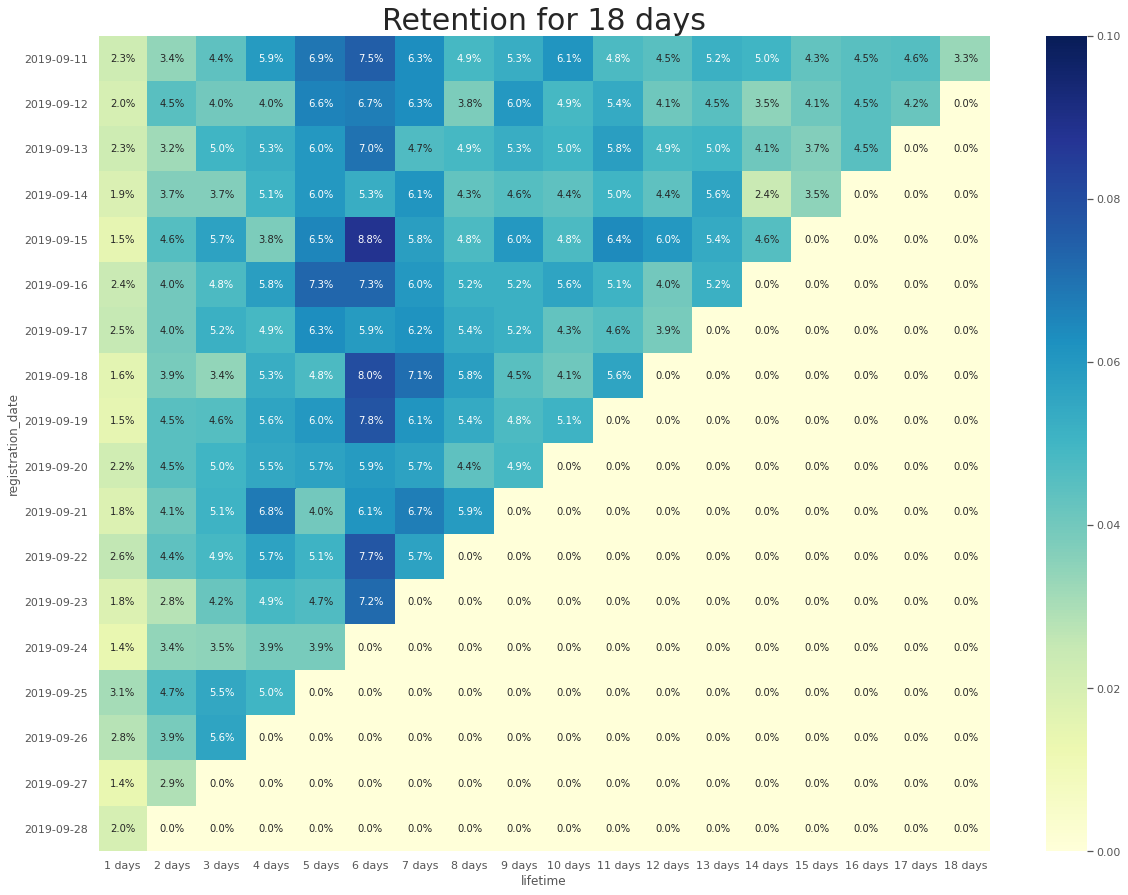

In [26]:
# Проверяем функцию. 
func_retention(data = df_1, start = '2019-09-11', finish = '2019-09-30')

### Выводы
Могу сделать предположение, что данные искуственные. 
1. Retention не зависит от месяца. Отсутствует сезонность. Возможно это связано с отсутствием каких-либо фич, батлпасов, эвентов
2. Самый большой показатель на пятый-шестой день.